In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
bs = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.72MB/s]


In [3]:
import torch
import torch.nn as nn

class ConditionalGenerator(nn.Module):
    def __init__(self, z_dim, num_classes, img_channels=1):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim + num_classes, 128, kernel_size=7, stride=1, padding=0),  # 7x7
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),  # 28x28
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([z, label_embedding], dim=1)
        x = x.view(x.size(0), x.size(1), 1, 1)
        return self.net(x)


class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes, img_channels=1):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.net = nn.Sequential(
            nn.Conv2d(img_channels + num_classes, 64, kernel_size=4, stride=2, padding=1),  # 14x14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        label_embedding = self.label_emb(labels)  # [B, num_classes]
        label_map = label_embedding.view(labels.size(0), -1, 1, 1)  # ✅ Correct!
        label_map = label_map.expand(-1, -1, x.size(2), x.size(3))  # [B, num_classes, 28, 28]
        x = torch.cat([x, label_map], dim=1)  # [B, 1+num_classes, 28, 28]
        return self.net(x)



In [4]:
z_dim = 100
num_classes = 10

G = ConditionalGenerator(z_dim=z_dim, num_classes=num_classes).to(device)
D = ConditionalDiscriminator(num_classes=num_classes).to(device)

In [5]:
G

ConditionalGenerator(
  (label_emb): Embedding(10, 10)
  (net): Sequential(
    (0): ConvTranspose2d(110, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Tanh()
  )
)

In [6]:
D

ConditionalDiscriminator(
  (label_emb): Embedding(10, 10)
  (net): Sequential(
    (0): Conv2d(11, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=6272, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [7]:
criterion = nn.BCELoss()
lr = 0.0002

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [8]:
def D_train(real_images, real_labels):
    D.zero_grad()

    bs = real_images.size(0)

    # === Train on real images ===
    y_real = torch.ones(bs, 1).to(device)
    real_images = real_images.to(device)
    real_labels = real_labels.to(device)

    D_output_real = D(real_images, real_labels)
    D_real_loss = criterion(D_output_real, y_real)

    # === Train on fake images ===
    z = torch.randn(bs, z_dim).to(device)
    fake_images = G(z, real_labels)  # condition on same labels

    y_fake = torch.zeros(bs, 1).to(device)
    D_output_fake = D(fake_images.detach(), real_labels)
    D_fake_loss = criterion(D_output_fake, y_fake)

    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return D_loss.item()

In [9]:
def G_train(labels):
    G.zero_grad()

    bs = labels.size(0)
    z = torch.randn(bs, z_dim).to(device)
    labels = labels.to(device)

    y_real = torch.ones(bs, 1).to(device)  # generator wants D to think fake is real
    fake_images = G(z, labels)
    D_output = D(fake_images, labels)

    G_loss = criterion(D_output, y_real)
    G_loss.backward()
    G_optimizer.step()

    return G_loss.item()


In [12]:
import os
import shutil
from google.colab import files


save_dir = "/content/samples"
os.makedirs(save_dir, exist_ok=True)

n_epoch = 20
bs = 100
sample_size = 10  # one digit from 0 to 9

for epoch in range(1, n_epoch + 1):
    G.train()
    D.train()
    D_losses, G_losses = [], []

    for batch_idx, (real_images, real_labels) in enumerate(train_loader):
        d_loss = D_train(real_images, real_labels)
        g_loss = G_train(real_labels)
        D_losses.append(d_loss)
        G_losses.append(g_loss)

    avg_d_loss = torch.mean(torch.FloatTensor(D_losses))
    avg_g_loss = torch.mean(torch.FloatTensor(G_losses))
    print(f"[{epoch}/{n_epoch}]: loss_d: {avg_d_loss:.3f}, loss_g: {avg_g_loss:.3f}")

    # Save 1 sample per digit after each epoch
    G.eval()
    with torch.no_grad():
        test_labels = torch.arange(0, 10).long().to(device)
        test_z = torch.randn(10, z_dim).to(device)
        generated = G(test_z, test_labels)

        save_path = os.path.join(save_dir, f'generated_epoch_{epoch}.png')
        save_image(generated, save_path, nrow=10, normalize=True)
        print(f"Saved samples for epoch {epoch} to {save_path}")

# Zip the folder of images
zip_path = "/content/generated_digits"
shutil.make_archive(zip_path, 'zip', save_dir)

# Download to your computer
files.download(zip_path + ".zip")

[1/20]: loss_d: 1.324, loss_g: 0.802
Saved samples for epoch 1 to /content/samples/generated_epoch_1.png
[2/20]: loss_d: 1.353, loss_g: 0.773
Saved samples for epoch 2 to /content/samples/generated_epoch_2.png
[3/20]: loss_d: 1.363, loss_g: 0.764
Saved samples for epoch 3 to /content/samples/generated_epoch_3.png
[4/20]: loss_d: 1.366, loss_g: 0.757
Saved samples for epoch 4 to /content/samples/generated_epoch_4.png
[5/20]: loss_d: 1.363, loss_g: 0.755
Saved samples for epoch 5 to /content/samples/generated_epoch_5.png
[6/20]: loss_d: 1.362, loss_g: 0.760
Saved samples for epoch 6 to /content/samples/generated_epoch_6.png
[7/20]: loss_d: 1.357, loss_g: 0.763
Saved samples for epoch 7 to /content/samples/generated_epoch_7.png
[8/20]: loss_d: 1.352, loss_g: 0.765
Saved samples for epoch 8 to /content/samples/generated_epoch_8.png
[9/20]: loss_d: 1.344, loss_g: 0.772
Saved samples for epoch 9 to /content/samples/generated_epoch_9.png
[10/20]: loss_d: 1.339, loss_g: 0.778
Saved samples for

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
# Folder to save individual digit images
digit_save_dir = "/content/digits"
os.makedirs(digit_save_dir, exist_ok=True)

# Generate one image for each digit (0–9)
G.eval()
with torch.no_grad():
    for digit in range(10):
        z = torch.randn(1, z_dim).to(device)
        label = torch.tensor([digit]).to(device)
        generated = G(z, label)

        # Save each image individually
        save_path = os.path.join(digit_save_dir, f'digit_{digit}.png')
        save_image(generated, save_path, normalize=True)
        print(f"Saved digit {digit} to {save_path}")

# Zip the folder containing all digit images
zip_path = "/content/digit_images"
shutil.make_archive(zip_path, 'zip', digit_save_dir)

# Download the zip file
files.download(zip_path + ".zip")

Saved digit 0 to /content/digits/digit_0.png
Saved digit 1 to /content/digits/digit_1.png
Saved digit 2 to /content/digits/digit_2.png
Saved digit 3 to /content/digits/digit_3.png
Saved digit 4 to /content/digits/digit_4.png
Saved digit 5 to /content/digits/digit_5.png
Saved digit 6 to /content/digits/digit_6.png
Saved digit 7 to /content/digits/digit_7.png
Saved digit 8 to /content/digits/digit_8.png
Saved digit 9 to /content/digits/digit_9.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
from google.colab import files
files.download(save_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# Save Generator
torch.save(G.state_dict(), "/content/generator.pth")

# Save Discriminator
torch.save(D.state_dict(), "/content/discriminator.pth")

In [16]:
# Download generator
files.download("/content/generator.pth")

# Download discriminator
files.download("/content/discriminator.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
torch.save(G, "/content/generator_full.pth")

In [18]:
files.download("/content/generator_full.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Enter a digit (0–9) to generate: 5


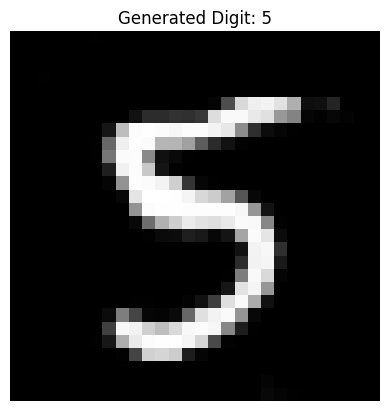

In [3]:
import torch
import torch.nn as nn
from torchvision.transforms.functional import to_pil_image
from IPython.display import display
import matplotlib.pyplot as plt

# === Generator class ===
class ConditionalGenerator(nn.Module):
    def __init__(self, z_dim, num_classes, img_channels=1):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim + num_classes, 128, 7, 1, 0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, 4, 2, 1),
            nn.Tanh()
        )
    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([z, label_embedding], dim=1)
        x = x.view(x.size(0), -1, 1, 1)
        return self.net(x)

# === Load Generator ===
z_dim = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = ConditionalGenerator(z_dim=z_dim, num_classes=10).to(device)
G.load_state_dict(torch.load("/content/generator.pth", map_location=device))
G.eval()

# === Get user input ===
digit = int(input("Enter a digit (0–9) to generate: "))
if digit < 0 or digit > 9:
    raise ValueError("Please enter a number between 0 and 9.")

# === Generate ===
with torch.no_grad():
    z = torch.randn(1, z_dim).to(device)
    label = torch.tensor([digit]).to(device)
    generated = G(z, label)  # [1, 1, 28, 28]

# === Fix the black image: rescale from [-1, 1] to [0, 1] ===
generated_rescaled = (generated + 1) / 2  # now values are in [0, 1]

# === Display the image ===
img = to_pil_image(generated_rescaled.squeeze(0).cpu())  # no need for mode='F' now
plt.imshow(img, cmap='gray')
plt.title(f"Generated Digit: {digit}")
plt.axis('off')
plt.show()
